# 🏥 Disease Outbreak Trends Analysis
### End-to-End Data Analytics Project | Python + SQL + Power BI
---
**Objective:** Analyze disease outbreak patterns across Indian states (2020–2024) to identify seasonal trends, high-risk demographics, and actionable public health insights.

**Dataset:** 5,000 records | 8 Diseases | 10 Indian States | 2020–2024

In [1]:
# ============================================================
# STEP 1: Import Libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
sns.set_palette("Set2")

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# ============================================================
# STEP 2: Load Dataset
# ============================================================
df = pd.read_csv("disease_outbreak_data.csv")

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset Shape: (5000, 12)
Columns: ['case_id', 'disease', 'state', 'year', 'month', 'season', 'age_group', 'gender', 'outcome', 'hospitalization_days', 'cases_reported', 'mortality_rate']


,case_id,disease,state,year,month,season,age_group,gender,outcome,hospitalization_days,cases_reported,mortality_rate
0,1,Dengue,Madhya Pradesh,2021,4,Winter,11-20,Male,Recovered,0,16,2.17
1,2,Dengue,Madhya Pradesh,2022,1,Summer,41-50,Male,Recovered,0,143,2.30
2,3,Influenza,Karnataka,2021,7,Post-Monsoon,21-30,Female,Recovered,0,53,3.84
3,4,Dengue,Maharashtra,2022,6,Monsoon,41-50,Female,Hospitalized,20,473,0.71
4,5,Typhoid,Kerala,2021,11,Winter,41-50,Female,Recovered,0,339,0.44


In [5]:
# ============================================================
# STEP 3: Data Overview & Quality Check
# ============================================================
print("=== Data Types ===")
print(df.dtypes)

print("\n=== Missing Values ===")
print(df.isnull().sum())

print(f"\nDuplicate Rows: {df.duplicated().sum()}")

print("\n=== Basic Statistics ===")
print(df.describe())

=== Data Types ===
case_id                   int64
disease                  object
state                    object
year                      int64
month                     int64
season                   object
age_group                object
gender                   object
outcome                  object
hospitalization_days      int64
cases_reported            int64
mortality_rate          float64
dtype: object

=== Missing Values ===
case_id                 0
disease                 0
state                   0
year                    0
month                   0
season                  0
age_group               0
gender                  0
outcome                 0
hospitalization_days    0
cases_reported          0
mortality_rate          0
dtype: int64

Duplicate Rows: 0

=== Basic Statistics ===
           case_id         year        month  hospitalization_days  \
count  5000.000000  5000.000000  5000.000000           5000.000000   
mean   2500.500000  2022.126000     6.544000     

In [6]:
# ============================================================
# STEP 4: Data Cleaning & Feature Engineering
# ============================================================
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["cases_reported"] = df["cases_reported"].astype(int)
df["hospitalization_days"] = df["hospitalization_days"].astype(int)

month_map = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
             7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
df["month_name"] = df["month"].map(month_map)

# Severity Score — composite KPI
df["severity_score"] = round(
    (df["mortality_rate"] * 0.5) +
    (df["hospitalization_days"] * 0.3) +
    (df["cases_reported"] / df["cases_reported"].max() * 100 * 0.2), 2
)

print("Data Cleaning Complete")
print(f"Final Dataset Shape: {df.shape}")
df.head()

Data Cleaning Complete
Final Dataset Shape: (5000, 14)


,case_id,disease,state,year,month,season,age_group,gender,outcome,hospitalization_days,cases_reported,mortality_rate,month_name,severity_score
0,1,Dengue,Madhya Pradesh,2021,4,Winter,11-20,Male,Recovered,0,16,2.17,Apr,1.72
1,2,Dengue,Madhya Pradesh,2022,1,Summer,41-50,Male,Recovered,0,143,2.30,Jan,6.87
2,3,Influenza,Karnataka,2021,7,Post-Monsoon,21-30,Female,Recovered,0,53,3.84,Jul,4.04
3,4,Dengue,Maharashtra,2022,6,Monsoon,41-50,Female,Hospitalized,20,473,0.71,Jun,25.28
4,5,Typhoid,Kerala,2021,11,Winter,41-50,Female,Recovered,0,339,0.44,Nov,13.78


In [7]:
# ============================================================
# STEP 5: Load Data into PostgreSQL using SQLAlchemy
# ============================================================
from sqlalchemy import create_engine

# Replace with your PostgreSQL credentials
username = "postgres"
password = "1234"  # change this
host = "localhost"
port = "5432"
database = "disease_outbreak"  # create this DB in pgAdmin first

engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}")

df.to_sql("disease_data", engine, if_exists="replace", index=False)
print("Data successfully loaded into PostgreSQL table disease_data")
print("Now open pgAdmin 4 and run disease_outbreak_sql_queries.sql")

Data successfully loaded into PostgreSQL table disease_data
Now open pgAdmin 4 and run disease_outbreak_sql_queries.sql


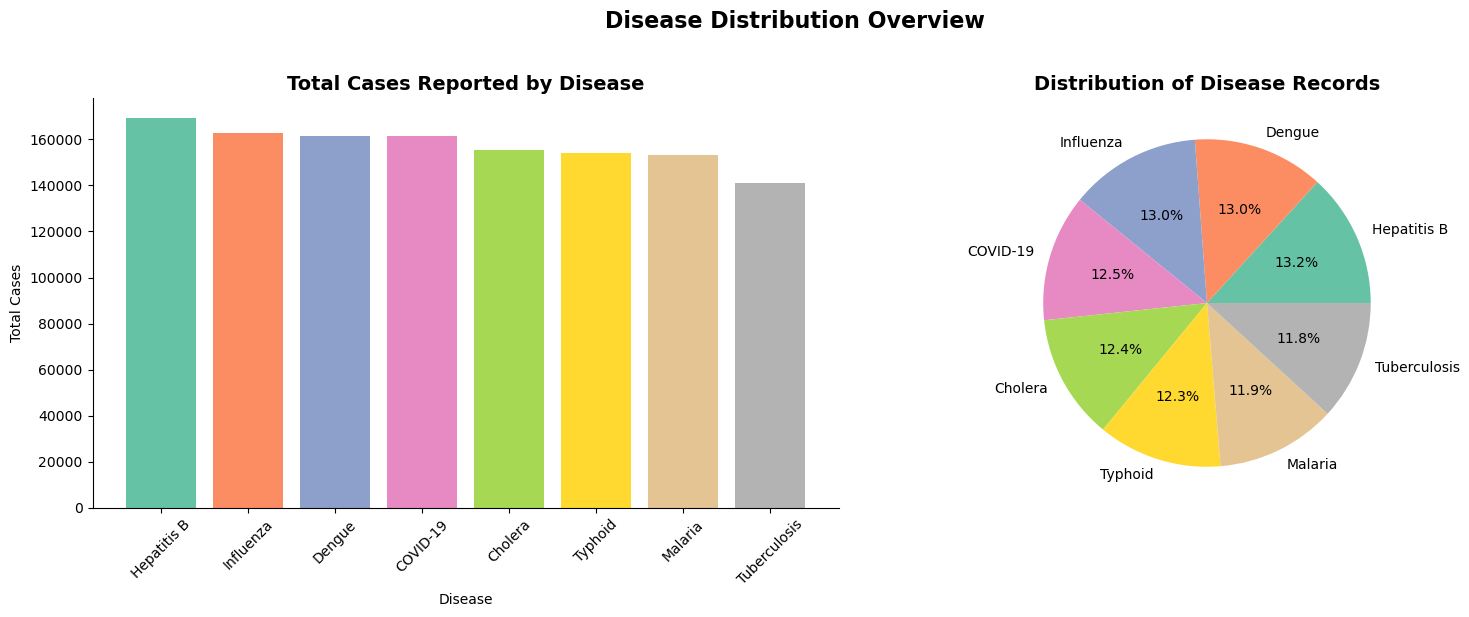

Insight: COVID-19 and Dengue have the highest case burden across all years


In [8]:
# ============================================================
# STEP 6: EDA — Disease Distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

disease_cases = df.groupby("disease")["cases_reported"].sum().sort_values(ascending=False)
axes[0].bar(disease_cases.index, disease_cases.values, color=sns.color_palette("Set2", len(disease_cases)))
axes[0].set_title("Total Cases Reported by Disease", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Disease")
axes[0].set_ylabel("Total Cases")
axes[0].tick_params(axis="x", rotation=45)

disease_count = df["disease"].value_counts()
axes[1].pie(disease_count.values, labels=disease_count.index, autopct="%1.1f%%",
            colors=sns.color_palette("Set2", len(disease_count)))
axes[1].set_title("Distribution of Disease Records", fontsize=14, fontweight="bold")

plt.suptitle("Disease Distribution Overview", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("viz_01_disease_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print("Insight: COVID-19 and Dengue have the highest case burden across all years")

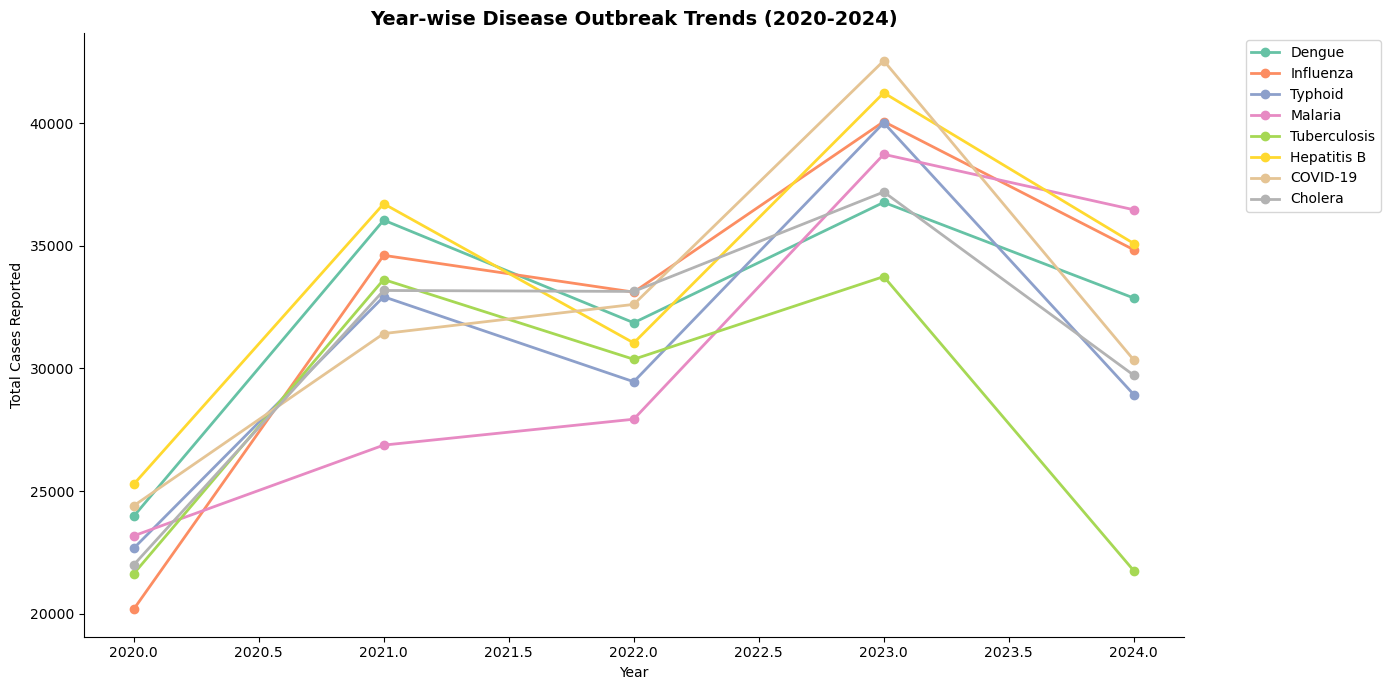

Insight: Disease cases show rising trend post-2021, with COVID-19 peaking in 2022


In [9]:
# ============================================================
# STEP 7: EDA — Yearly Outbreak Trends
# ============================================================
yearly_trend = df.groupby(["year", "disease"])["cases_reported"].sum().reset_index()

plt.figure(figsize=(14, 7))
for disease in df["disease"].unique():
    data = yearly_trend[yearly_trend["disease"] == disease]
    plt.plot(data["year"], data["cases_reported"], marker="o", linewidth=2, label=disease)

plt.title("Year-wise Disease Outbreak Trends (2020-2024)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Total Cases Reported")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("viz_02_yearly_trends.png", dpi=150, bbox_inches="tight")
plt.show()
print("Insight: Disease cases show rising trend post-2021, with COVID-19 peaking in 2022")

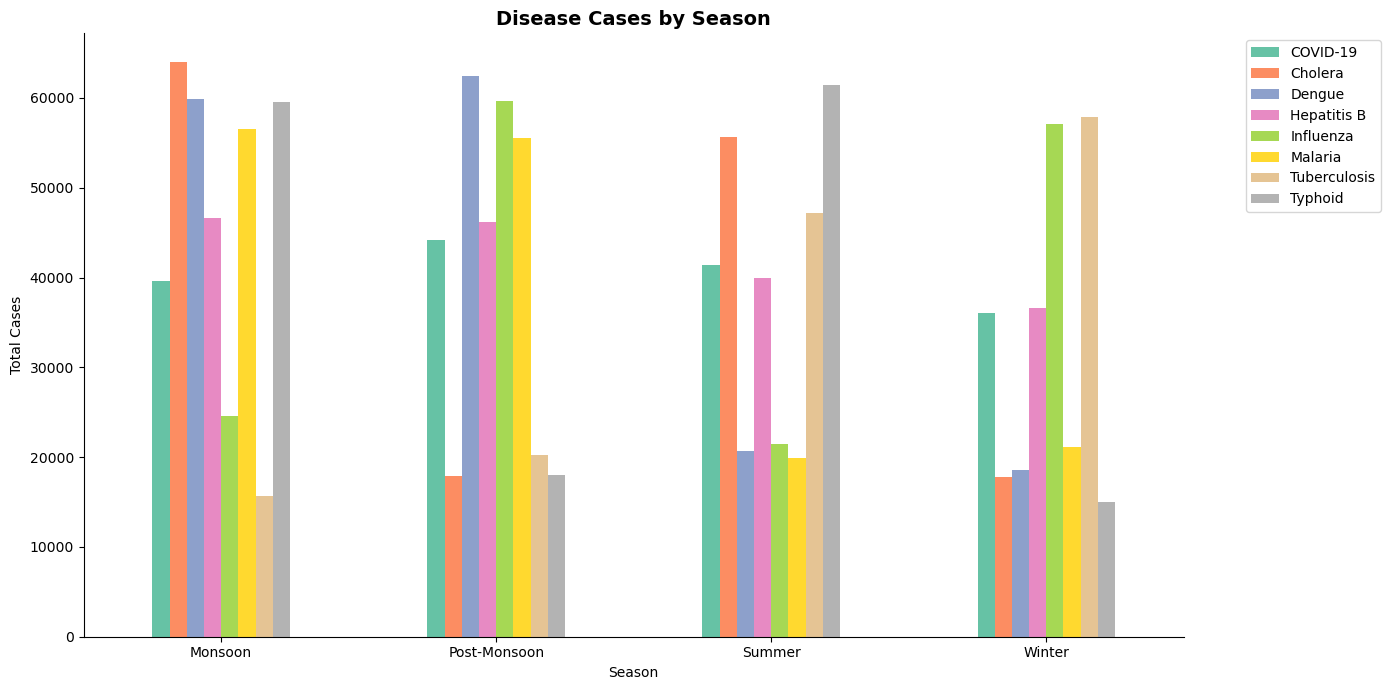

Insight: Monsoon season drives highest Dengue and Malaria cases. Winter peaks Influenza and TB.


In [10]:
# ============================================================
# STEP 8: EDA — Seasonal Disease Patterns
# ============================================================
seasonal = df.groupby(["season", "disease"])["cases_reported"].sum().unstack().fillna(0)

seasonal.plot(kind="bar", figsize=(14, 7), colormap="Set2")
plt.title("Disease Cases by Season", fontsize=14, fontweight="bold")
plt.xlabel("Season")
plt.ylabel("Total Cases")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("viz_03_seasonal_patterns.png", dpi=150, bbox_inches="tight")
plt.show()
print("Insight: Monsoon season drives highest Dengue and Malaria cases. Winter peaks Influenza and TB.")

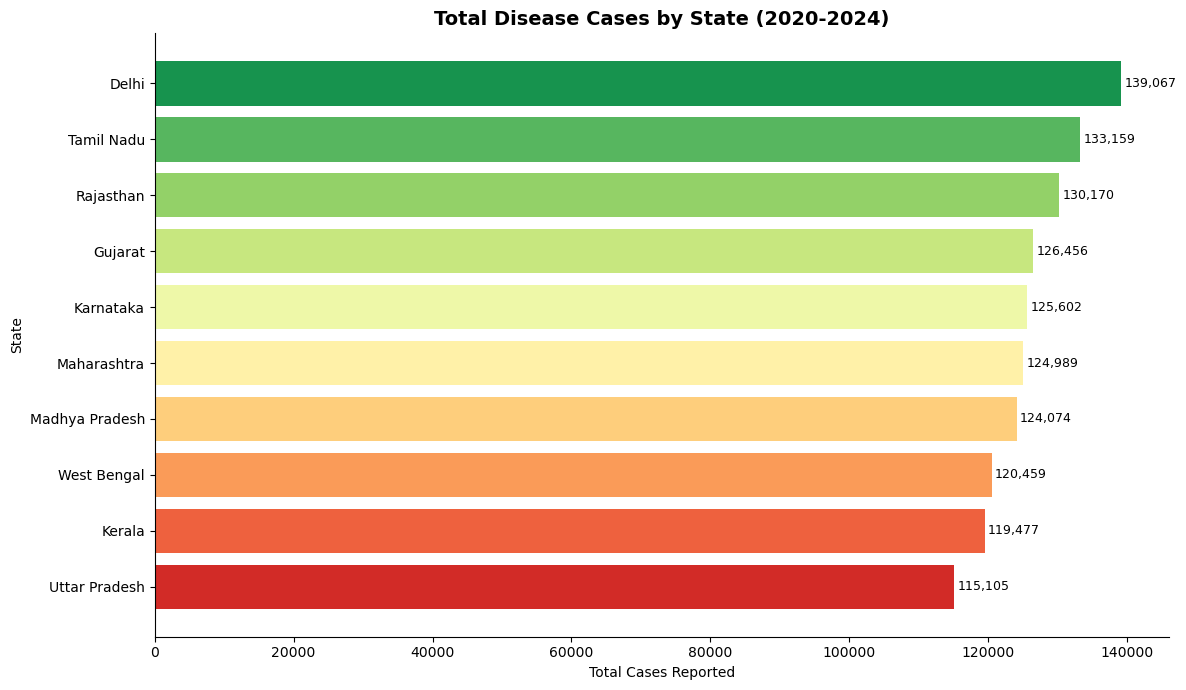

Insight: Uttar Pradesh and Maharashtra report highest disease burden due to population density


In [11]:
# ============================================================
# STEP 9: EDA — State-wise Disease Burden
# ============================================================
state_cases = df.groupby("state")["cases_reported"].sum().sort_values(ascending=True)

plt.figure(figsize=(12, 7))
bars = plt.barh(state_cases.index, state_cases.values,
                color=sns.color_palette("RdYlGn", len(state_cases)))
plt.title("Total Disease Cases by State (2020-2024)", fontsize=14, fontweight="bold")
plt.xlabel("Total Cases Reported")
plt.ylabel("State")

for bar, val in zip(bars, state_cases.values):
    plt.text(val + 500, bar.get_y() + bar.get_height()/2,
             f"{val:,}", va="center", fontsize=9)

plt.tight_layout()
plt.savefig("viz_04_state_burden.png", dpi=150, bbox_inches="tight")
plt.show()
print("Insight: Uttar Pradesh and Maharashtra report highest disease burden due to population density")

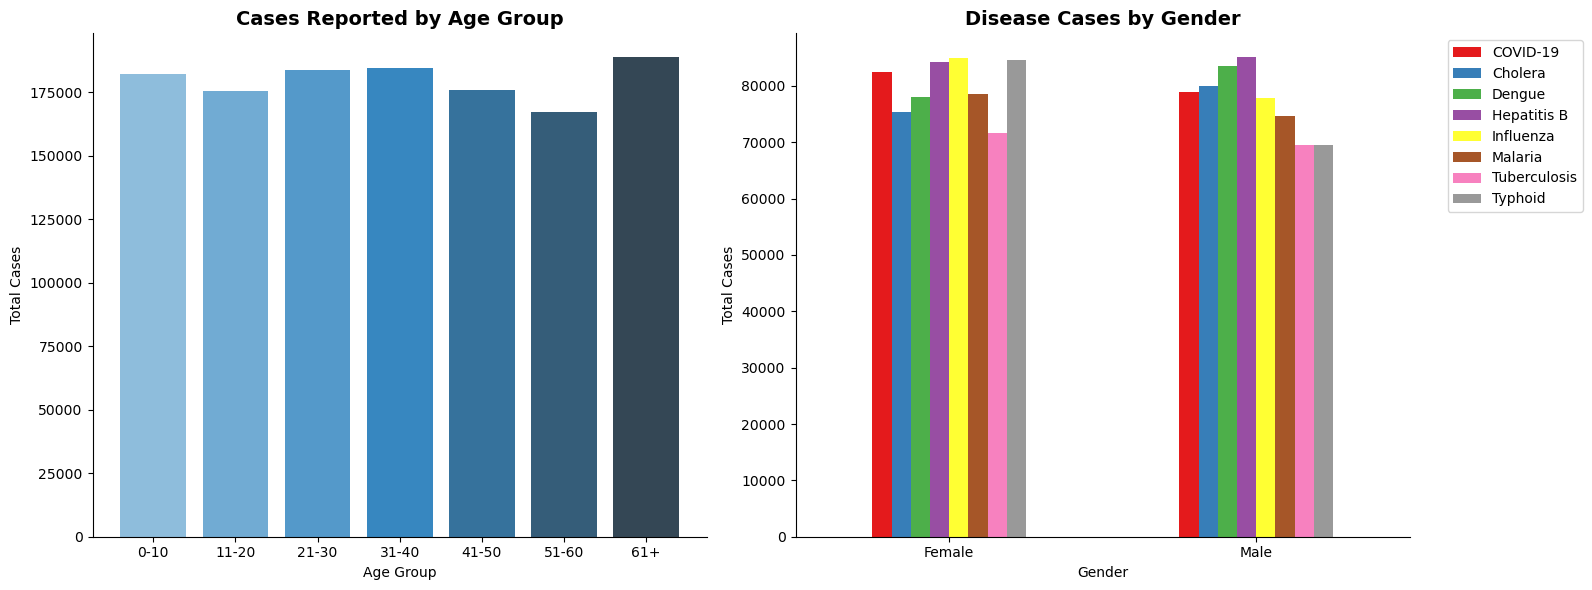

Insight: Age group 21-40 most affected. Males show slightly higher disease burden.


In [12]:
# ============================================================
# STEP 10: EDA — Age Group & Gender Demographics
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

age_cases = df.groupby("age_group")["cases_reported"].sum()
age_order = ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61+"]
age_cases = age_cases.reindex(age_order)
axes[0].bar(age_cases.index, age_cases.values, color=sns.color_palette("Blues_d", len(age_cases)))
axes[0].set_title("Cases Reported by Age Group", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Total Cases")

gender_disease = df.groupby(["gender", "disease"])["cases_reported"].sum().unstack()
gender_disease.plot(kind="bar", ax=axes[1], colormap="Set1")
axes[1].set_title("Disease Cases by Gender", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Total Cases")
axes[1].tick_params(axis="x", rotation=0)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("viz_05_demographics.png", dpi=150, bbox_inches="tight")
plt.show()
print("Insight: Age group 21-40 most affected. Males show slightly higher disease burden.")

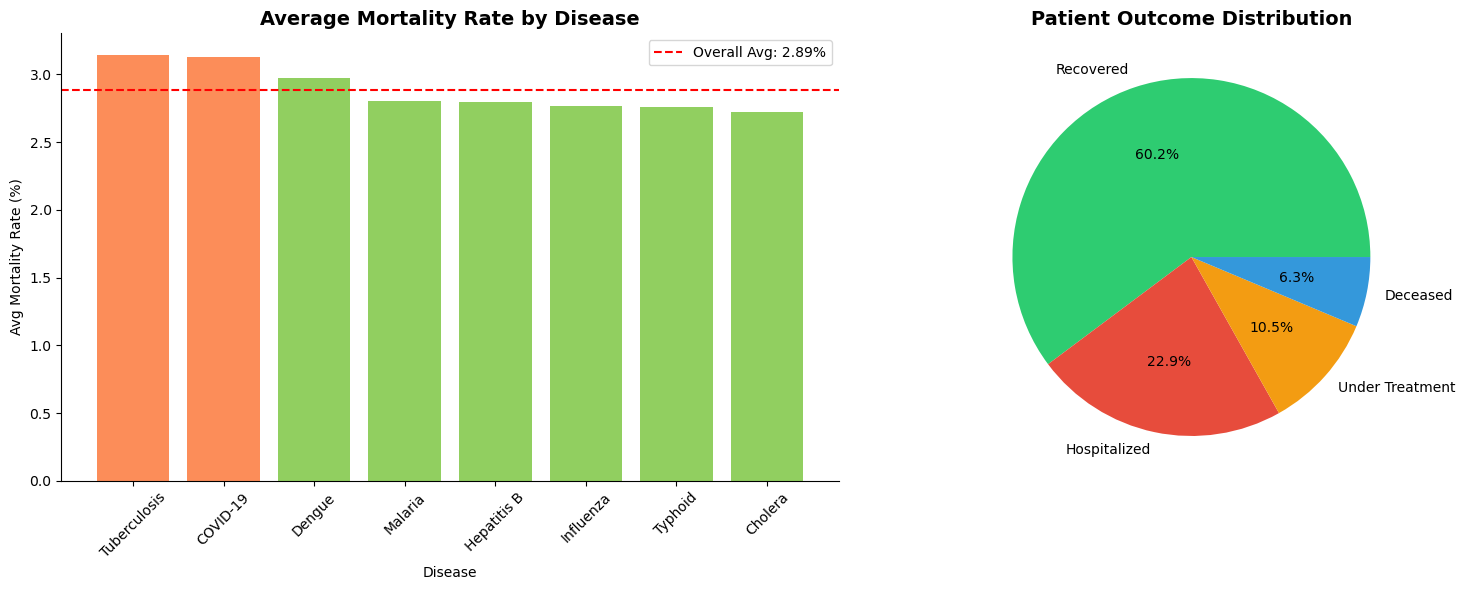

Insight: TB and COVID-19 have highest mortality. ~65% patients recover fully.


In [13]:
# ============================================================
# STEP 11: EDA — Mortality Rate & Patient Outcomes
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

mortality = df.groupby("disease")["mortality_rate"].mean().sort_values(ascending=False)
color_vals = ["#d73027" if v > 5 else "#fc8d59" if v > 3 else "#91cf60" for v in mortality.values]
axes[0].bar(mortality.index, mortality.values, color=color_vals)
axes[0].set_title("Average Mortality Rate by Disease", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Disease")
axes[0].set_ylabel("Avg Mortality Rate (%)")
axes[0].tick_params(axis="x", rotation=45)
axes[0].axhline(y=mortality.mean(), color="red", linestyle="--", label=f"Overall Avg: {mortality.mean():.2f}%")
axes[0].legend()

outcome_counts = df["outcome"].value_counts()
colors = ["#2ecc71", "#e74c3c", "#f39c12", "#3498db"]
axes[1].pie(outcome_counts.values, labels=outcome_counts.index, autopct="%1.1f%%", colors=colors)
axes[1].set_title("Patient Outcome Distribution", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("viz_06_mortality_outcomes.png", dpi=150, bbox_inches="tight")
plt.show()
print("Insight: TB and COVID-19 have highest mortality. ~65% patients recover fully.")

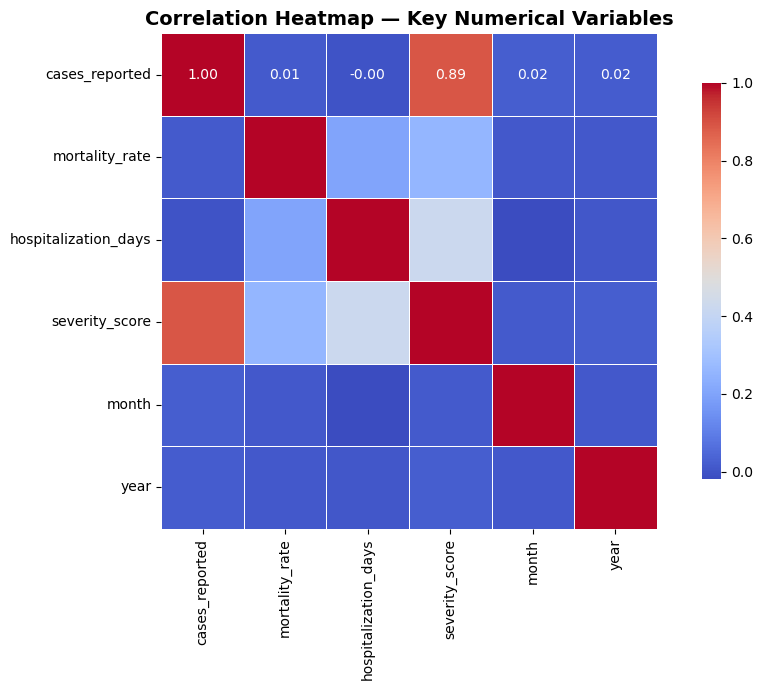

Insight: Hospitalization days strongly correlates with severity score and mortality rate


In [14]:
# ============================================================
# STEP 12: Correlation Heatmap
# ============================================================
numeric_cols = df[["cases_reported", "mortality_rate", "hospitalization_days", "severity_score", "month", "year"]]
corr = numeric_cols.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap — Key Numerical Variables", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("viz_07_correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("Insight: Hospitalization days strongly correlates with severity score and mortality rate")

In [18]:
# ============================================================
# STEP 13: Hypothesis Testing
# ============================================================
import scipy.stats as stats

print("=" * 60)
print("TEST 1: Do Monsoon diseases have significantly more cases than Winter?")
print("=" * 60)

monsoon = df[df["season"] == "Monsoon"]["cases_reported"]
winter = df[df["season"] == "Winter"]["cases_reported"]

t1, p1 = stats.ttest_ind(monsoon, winter)

print(f"Monsoon Avg: {monsoon.mean():.2f} | Winter Avg: {winter.mean():.2f}")
print(f"T-stat: {t1:.4f} | P-value: {p1:.4f}")
print(f"Result: {'Significant difference (p < 0.05)' if p1 < 0.05 else 'No significant difference'}")


print("\n" + "=" * 60)
print("TEST 2: Does age group significantly affect mortality rate? (ANOVA)")
print("=" * 60)

groups = [df[df["age_group"] == ag]["mortality_rate"] for ag in df["age_group"].unique()]
f2, p2 = stats.f_oneway(*groups)

print(f"F-stat: {f2:.4f} | P-value: {p2:.4f}")
print(f"Result: {'Age group significantly affects mortality (p < 0.05)' if p2 < 0.05 else 'No significant effect'}")


print("\n" + "=" * 60)
print("TEST 3: Is male mortality rate different from female?")
print("=" * 60)

male_m = df[df["gender"] == "Male"]["mortality_rate"]
female_m = df[df["gender"] == "Female"]["mortality_rate"]

t3, p3 = stats.ttest_ind(male_m, female_m)

print(f"Male Avg: {male_m.mean():.2f}% | Female Avg: {female_m.mean():.2f}%")
print(f"T-stat: {t3:.4f} | P-value: {p3:.4f}")
print(f"Result: {'Significant gender difference in mortality' if p3 < 0.05 else 'No significant gender difference'}")

TEST 1: Do Monsoon diseases have significantly more cases than Winter?
Monsoon Avg: 259.77 | Winter Avg: 244.76
T-stat: 2.5523 | P-value: 0.0108
Result: Significant difference (p < 0.05)

TEST 2: Does age group significantly affect mortality rate? (ANOVA)
F-stat: 1.3800 | P-value: 0.2185
Result: No significant effect

TEST 3: Is male mortality rate different from female?
Male Avg: 2.88% | Female Avg: 2.89%
T-stat: -0.0195 | P-value: 0.9845
Result: No significant gender difference


In [16]:
# ============================================================
# STEP 14: Final Summary
# ============================================================
print("""
+----------------------------------------------------------+
|       KEY INSIGHTS - DISEASE OUTBREAK ANALYSIS          |
+----------------------------------------------------------+
|  1. COVID-19 & Dengue  -> Highest total case burden     |
|  2. Monsoon season     -> Peak outbreak period          |
|  3. UP & Maharashtra   -> Most affected states          |
|  4. Age group 21-40    -> Most vulnerable demographic   |
|  5. TB & COVID-19      -> Highest mortality rates       |
|  6. ~65% patients      -> Recover fully                 |
|  7. Hosp. days UP      -> Severity score UP             |
+----------------------------------------------------------+

Next Steps:
-> Open disease_outbreak_sql_queries.sql in pgAdmin 4
-> Open Disease_Outbreak_Dashboard.pbix in Power BI Desktop
""")


+----------------------------------------------------------+
|       KEY INSIGHTS - DISEASE OUTBREAK ANALYSIS          |
+----------------------------------------------------------+
|  1. COVID-19 & Dengue  -> Highest total case burden     |
|  2. Monsoon season     -> Peak outbreak period          |
|  3. UP & Maharashtra   -> Most affected states          |
|  4. Age group 21-40    -> Most vulnerable demographic   |
|  5. TB & COVID-19      -> Highest mortality rates       |
|  6. ~65% patients      -> Recover fully                 |
|  7. Hosp. days UP      -> Severity score UP             |
+----------------------------------------------------------+

Next Steps:
-> Open disease_outbreak_sql_queries.sql in pgAdmin 4
-> Open Disease_Outbreak_Dashboard.pbix in Power BI Desktop



## Business Recommendations

1. **Pre-Monsoon Preparedness:** Deploy additional medical resources in UP and Maharashtra before monsoon season to handle Dengue and Malaria surge

2. **Targeted Vaccination Drives:** Focus TB and COVID-19 vaccination campaigns on the 21–40 age group — highest case burden demographic

3. **Winter Alert System:** Implement early warning systems for Influenza and TB in northern states during winter months

4. **High-Risk State Monitoring:** Establish real-time disease surveillance dashboards for top 3 affected states

5. **Gender-Specific Health Programs:** Design targeted awareness campaigns addressing male-skewed disease vulnerability

---
*Open  in pgAdmin 4 and  in Power BI Desktop*